# Generate a first image, then derivate with a second prompt

## Install requirements

In [1]:
!python.exe -m pip install --upgrade pip

Defaulting to user installation because normal site-packages is not writeable


In [2]:
%pip install -r requirements-torch-windows.txt -U
%pip install -r requirements.txt -U

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://download.pytorch.org/whl/cu117
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## Init stable diffusion

In [3]:
from diffusers import StableDiffusionPipeline, DPMSolverMultistepScheduler
import torch

def initdiffusionpipeline(model_id):
    # Use the DPMSolverMultistepScheduler (DPM-Solver++) scheduler here instead
    pipe = StableDiffusionPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
    pipe.scheduler = DPMSolverMultistepScheduler.from_config(pipe.scheduler.config)
    pipe = pipe.to("cuda")
    return pipe

#diffusionpipeline=initdiffusionpipeline("stabilityai/stable-diffusion-2-1")
diffusionpipeline=initdiffusionpipeline("dreamlike-art/dreamlike-diffusion-1.0")

C:\Users\key\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
text_encoder\model.safetensors not found
Loading pipeline components...: 100%|██████████| 5/5 [00:01<00:00,  3.17it/s]


In [4]:
from diffusers import StableDiffusionUpscalePipeline

def initupscalepipeline(model_id):
    pipeline = StableDiffusionUpscalePipeline.from_pretrained(model_id, torch_dtype=torch.float16)
    pipeline.enable_attention_slicing() 
    pipeline = pipeline.to("cuda")
    return pipeline

upscalepipeline=initupscalepipeline("stabilityai/stable-diffusion-x4-upscaler")

text_encoder\model.safetensors not found
Loading pipeline components...: 100%|██████████| 6/6 [00:03<00:00,  1.72it/s]


In [5]:
from diffusers import StableDiffusionImg2ImgPipeline

def initimg2imgpipeline(model_id):
    pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, torch_dtype=torch.float16)
    pipe = pipe.to("cuda")
    return pipe

img2imgpipeline = initimg2imgpipeline("runwayml/stable-diffusion-v1-5")

safety_checker\model.safetensors not found
Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]




Fetching 15 files:   7%|▋         | 1/15 [00:00<00:02,  4.67it/s]






































































































































































































































































































































































































































Fetching 15 files:  27%|██▋       | 4/15 [00:30<01:29,  8.15s/it]















































































































































































































Loading pipeline components...:  29%|██▊       | 2/7 [00:00<00:01,  2.90it/s]`text_config_dict` is provided which will be used to init

In [6]:
import re
def saveimage(image, prompt, seed, postfix=""):
    cleanprompt = re.sub("( |,)", '-', prompt)
    fname = f"images/{cleanprompt}-{seed}-{postfix}.png"
    image.save(fname)
    print(fname)
    display(image)
    #image.show() # open outside

In [7]:
def generate(prompt,nbimages=1,seed=42):
    images = []
    for i in range(nbimages):
        generator = torch.Generator("cuda").manual_seed(seed+i)
        image = diffusionpipeline(prompt,num_images_per_prompt=1, generator=generator).images[0]
        saveimage(image, prompt, seed+i)
        images.append(image)
    #images = diffusionpipeline(prompt,num_images_per_prompt=nbimages, generator=generator).images
    return images

In [8]:
def derivate(srcimg, prompt, nbimages=1,seed=42):
    images = []
    for i in range(nbimages):
        generator = torch.Generator("cuda").manual_seed(seed+i)
        image = img2imgpipeline(prompt=prompt, image=srcimg, strength=0.75, guidance_scale=7.5,num_images_per_prompt=1, generator=generator).images[0]
        saveimage(image, prompt, seed+i, "derived")
        images.append(image)
    #images = img2imgpipeline(prompt=prompt, image=srcimg, strength=0.75, guidance_scale=7.5,num_images_per_prompt=nbimages, generator=generator).images
    return images

In [9]:
def upscale(prompt,srcimg,seed=42):
    generator = torch.Generator("cuda").manual_seed(seed)
    image = upscalepipeline(prompt=prompt, image=srcimg,generator=generator).images[0]
    saveimage(image, prompt, seed, "upscaled")
    return image

## Run

100%|██████████| 50/50 [00:06<00:00,  7.36it/s]


images/imagine-a-prehistoric-octopus-42-.png


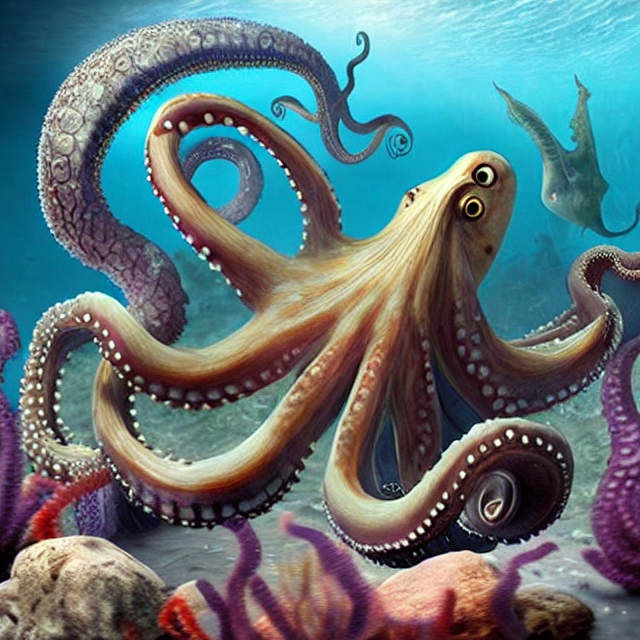

100%|██████████| 50/50 [00:06<00:00,  8.04it/s]


images/imagine-a-prehistoric-octopus-43-.png


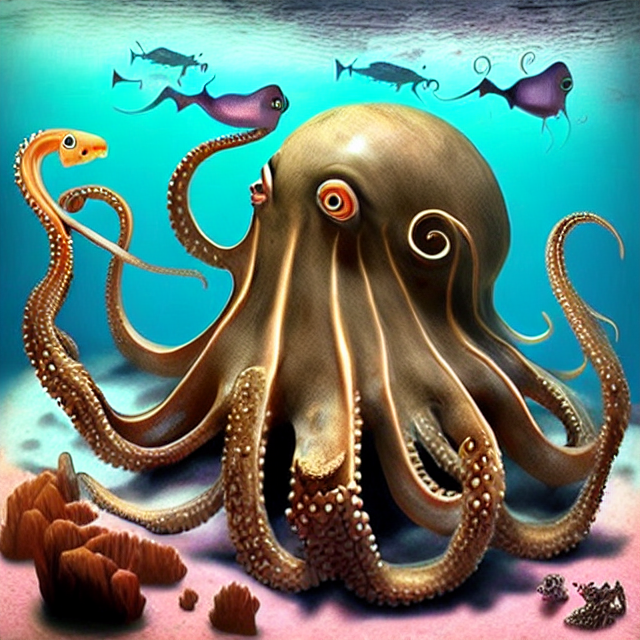

In [10]:
prompt="imagine a prehistoric octopus"
images=generate(prompt,2)

## Derivate

100%|██████████| 37/37 [00:04<00:00,  7.95it/s]


images/imagine-a-prehistoric-octopus-lurking-in-the-deep-green-blue-sea--deep-blue-shadows-and-sun-rays--undersea-jungle--high-definition-rendering-42-derived.png


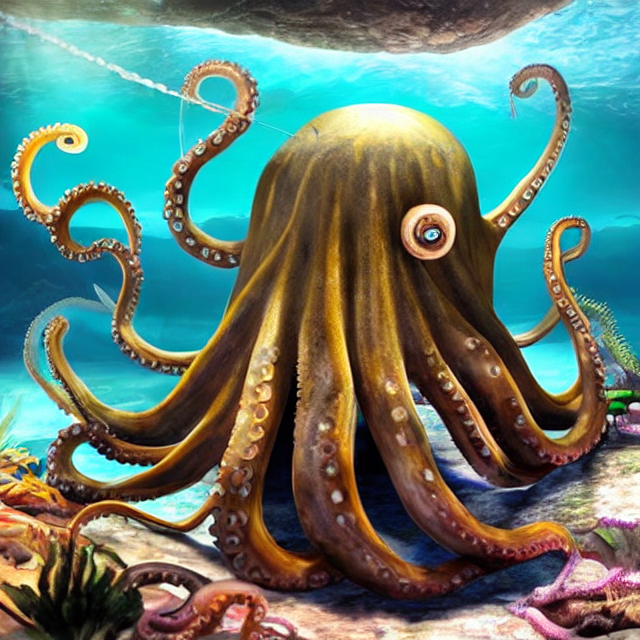

In [12]:
srcimg = images[1]
prompt2="imagine a prehistoric octopus lurking in the deep green blue sea, deep blue shadows and sun rays, undersea jungle, high definition rendering"
derivateimages = derivate(srcimg, prompt2)